<a href="https://colab.research.google.com/github/johnlocke333/xray_image_classification/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project Submission**

*   Student name: Jack Locke
*   Student pace: Self-paced
*   Instructor name: Mark Barbour

# **Pneumonia Model Analysis**

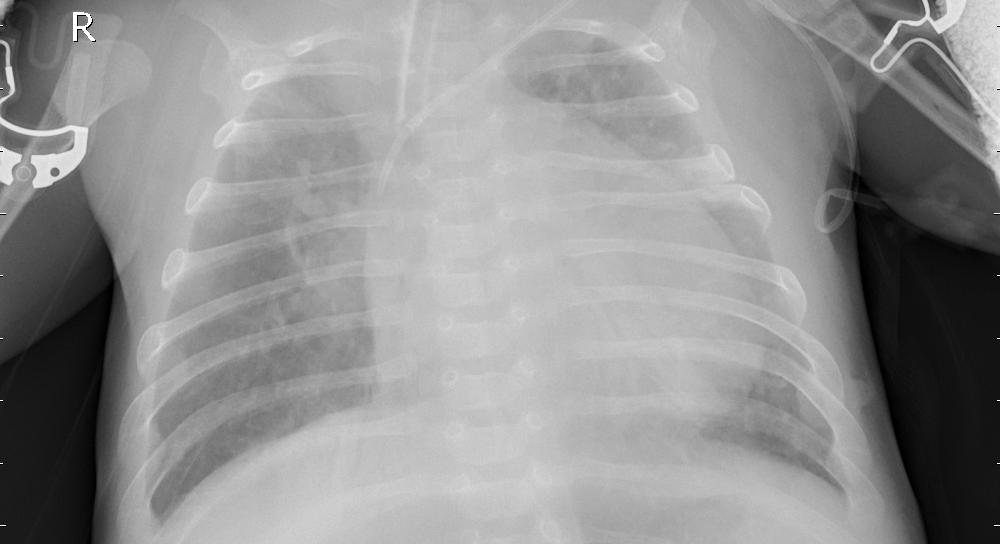

# **Overview**


1.  Business Understanding
2.  Data Understanding
3.  Data Preparation

  *   Directory path for train/test/valid images
  *   Create image/label datasets and reshape
  *   Change dimensions of images and labels
  *   Standardize images
  *   Class Imbalance - class weights



4.  Modeling
  *   Baseline
  *   Gridsearch/Tuned Model
  *   Regularization


5.  Evaluation

  *   Final Model
  *   LIME Interpretability



6.  Conclusions

  *   Limitations
  *   Recommendations/Next Steps




# **Business Understanding**

The business stakeholder is a diagnostic imaging center exploring the use of neural networks to help predict when patients have pneumonia. My project uses X-ray images of patients with and without pneumonia. The model aims to predict whether someone has pneumonia or not. The importance of the model revolves around the costs associated with false positives and false negatives. The false positive would be predicting someone does have pneumonia when they don’t (wasted time/resources/money). The false negative would be predicting someone didn't have pneumonia when they did (future health issues). I will find an appropriate trade-off between our two costs, focusing on minimizing future health issues. The imaging center can use the model to aid doctors in their decision-making, leading to better efficiency, accuracy, and decreased workload. All leading to more growth for the business. My analysis will use the CRISP-DM (Cross-industry standard process for data mining) methodology.

# **Data Understanding**

I am working with a dataset presented by Kaggle. The dataset was gathered from one medical center located in a prominent city in China, Guangzhou. “Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.” The dataset contains almost 6,000 images in two categories (Pneumonia/Normal). It is important to note that this is data from one location, and the images are all children, which causes some limitations. I will discuss these in more detail in the limitations section at the end of the notebook. Below is a link to the dataset.

1* Citation/Data: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download

# **Data Preparation**

The data needs some initial transformations/preparation to ensure the images can be used by the model. I have to change the shape and dimensions of the images and labels to do this. I also need to standardize the images to reduce their complexity, which will help improve model performance and efficiency. Additionally, class imbalance is present in the datasets, with the minority class being “normal”. Adjusting the class weights will provide more weight to the minority class and less weight to the majority class. This will help reduce bias within the model.

  * Directory path for train/test/valid images
  * Create image/label datasets and reshape
  * Change dimensions of images and labels
  * Standardize images
  * Class Imbalance - class weights



In [ ]:
#My environment required me to install certain packages and versions. Please check your environment to see if this is needed.
#If you need to do so then please uncomment the below code.

#!pip install scikeras
#!pip install scikit-learn==1.2.2
#!pip install lime
#!pip install scikit-image

In [ ]:
#Import the necessary libraries for image manipulation, graphing, preprocessing, modeling, metrics, and explainability. The imports are divided into sections in the order
#that they were initiated in the notebook.
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from IPython import get_ipython
from IPython.display import display

import lime
from lime import lime_image
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
#load the dataset in from kaggle, uncomment the below code to download the data.

#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
#unzip the dataset so it can be loaded into the notebook. Uncomment the below line in order to do so. I am commenting it out so it does not consume
#most of the notebook.

#!unzip chest-xray-pneumonia.zip

In [ ]:
# Directory path
train_data_dir = 'chest_xray/train'
test_data_dir = 'chest_xray/test'
valid_data_dir = 'chest_xray/val'

In [ ]:
# Get all the data from the directory, and reshape them to put into their datasets. Putting into function for reusability for train,test,valid.
def get_reshape_images(dir, bs):
  '''
  The function will take in the directory path (dir) for the image as well as the batch size (bs). It will reshape the image to (128,128) and assign the images to (images)
  and the labels to (labels).
  '''
  generator = ImageDataGenerator().flow_from_directory(
          dir, target_size=(128, 128), batch_size=bs)

  images, labels = next(generator)
  return images, labels

In [ ]:
#Using our function to reshape images and assign the train images and labels from the directory path.
train_images, train_labels = get_reshape_images(train_data_dir, 5216)

In [ ]:
#Using our function to reshape images and assign the test images and labels from the directory path.
test_images, test_labels = get_reshape_images(test_data_dir, 624)

In [ ]:
#Using our function to reshape images and assign the valid images and labels from the directory path.
valid_images, valid_labels = get_reshape_images(valid_data_dir, 16)

In [ ]:
 #Need to manipulate the dimensions of the images and labels so they can be passed into the model. For example, I want the images to be (5216,49152) and the labels to be
#(5216,1) for the training dataset.
 def reshape_input_image_label(images, m, labels):
  '''
  Will take in the image dataset (images) and reshape them to the desired outcome by using the amount of images (m) to get the required dimension for the model.
  It will also take in the label dataset (labels) and reshape them to the desired dimension needed for the model.
  '''
  img_unrow = images.reshape(m, -1)
  labels_final = labels.T[[1]].T
  return img_unrow, labels_final

In [ ]:
#Using our function to change dimensions of the train images and labels, with the total number of images in the dataset.
train_img_unrow, train_label_final = reshape_input_image_label(train_images, 5216, train_labels)

In [ ]:
#Using our function to change dimensions of the test images and labels, with the total number of images in the dataset.
test_img_unrow, test_label_final = reshape_input_image_label(test_images, 624, test_labels)

In [ ]:
#Using our function to change dimensions of the valid images and labels, with the total number of images in the dataset.
valid_img_unrow, valid_label_final = reshape_input_image_label(valid_images, 16, valid_labels)

In [ ]:
#I want to standardize the images for better efficiency and results. Helps reduce data complexity. Currently between 0 and 255 but want it to be
#between 0 and 1.
def standardize(img_unrow):
  '''
  Takes in the image dataset (img_unrow) and standardizes it.
  '''
  img_final = img_unrow/255
  return img_final

In [ ]:
#Standardize the train images.
train_img_final = standardize(train_img_unrow)

In [ ]:
#Standardize the test images.
test_img_final= standardize(test_img_unrow)

In [ ]:
#Standardize the valid images.
valid_img_final = standardize(valid_img_unrow)

In [ ]:
#Currently, the dataset has class imbalance in favor of pneumonia. To fix this I need to adjust the class weights. This will be implemented during model.fit().
class_weights_train = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_label_final),
                                     y=train_label_final.ravel())

#Convert to dictionary format so it can be passed into the model.fit.
class_weights_dict_train = {0: class_weights_train[0], 1: class_weights_train[1]}

#2*Citation

# **Model**

I am trying to assess two categories within an X-ray image, so I will use a binary image classification neural network. My goal to ensure my model performs the same on the training images as on unseen images. I will use the three different datasets to ensure the model is generalizable (train/test/valid). Since I am focused on minimizing the false negatives, I will be looking at recall as my metric for these models.

# *Baseline*

Modeling is an iterative process, so a baseline model is needed. I will use the baseline model as a reference point as I try to improve the performance of my model. I will create a simple model to represent this. The model will only contain two neurons in its initial layer. I chose an epoch of 6 and batch size of 3 because this combination ensures all images will be passed through the model when training the baseline. Because this is a binary image classification problem, the output layer must contain just one neuron, and the activation function must be “sigmoid.” When fit is applied, you see the use of class weights to handle class imbalance.
Additionally, you will see the model takes in the training data and uses the test data for comparison, helping better understand how generalizable the model is.  The train and test data showed similar loss metrics, but the recall score is scattered. To fix this issue, I will apply Gridsearch for the next model. The baseline model is currently in a function so it can be wrapped in order to be applied to Gridsearch.

# *Gridsearch/tuned model*

I am applying Gridsearch to find the optimal parameters for my model. I will examine the number of neurons, optimizer, activation function, epochs, and batch size. After receiving the best parameters, I applied them to the “tuned model.” The tuned model had much better and consistent recall values, showing improvement in the model overall. However, the loss is less for the training set than for the test set, which is a sign of overfitting. To fix overfitting, I must apply a regularization technique.

# *Regularization*

For this model, I applied the Dropout technique. This randomly selects neurons to use and removes the others (remember, my model currently has 20 neurons). This will reduce some of the noise the model is picking up on, which is causing it to overfit. The results for both the recall and loss scores show a decrease in overfitting from the tuned model. There is still a bit of overfitting, but if I continue to try and regularize the model, the metrics will start to fluctuate greatly. Given the limitations of the dataset, this is the best-performing model at this time. I will give a visual of the performance of the regularized model on the test images/labels via a confusion matrix.


*Side note:*

The models and gridsearch can take awhile to run. If you plan on experimenting with the models/results then I suggest saving after you run the models or gridsearch so you do not have to wait for results everytime. Here is some code from google colab to do so:

Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.

model.save("my_h5_model.h5")

Load model back in.

reconstructed_model = keras.models.load_model("my_h5_model.h5")

**Baseline Model**

In [ ]:
#Building baseline model. Passing into function so it can be used in gridsearch later.
def build_baseline(optimizer='SGD', activation='relu',neurons=2):
  baseline_model = models.Sequential()
  baseline_model.add(layers.Dense(neurons, activation=activation, input_shape=(49152,)))
  baseline_model.add(layers.Dense(1, activation='sigmoid'))
  baseline_model.compile(optimizer=optimizer,
                        loss='binary_crossentropy',
                        metrics=['recall'])
  return baseline_model


In [ ]:
#Fitting baseline model to see the results.
baseline_model = build_baseline()
baseline_model.fit(train_img_final,
                    train_label_final,
                    epochs=6,
                    batch_size=3,
                    class_weight = class_weights_dict_train,
                    validation_data=(test_img_final, test_label_final))

**Gridsearch/Tuned Model**

In [ ]:
#Apply early stoppage so the model reduces on the time spent running each epoch. Makes for better efficiency and reduce computation cost/time.
early_stopping = [EarlyStopping(monitor='val_loss', patience=5)]

#3*Citation

In [ ]:
#Wrap the model in KerasClassifier so it can be used for the gridsearch.
tuning_model=KerasClassifier(build_fn=build_baseline)

In [ ]:
#Create the grid to see what parameters work best for the model. The gridsearch can take a long time to run so I have removed certain factors I used when finding the
#best parameters so if you run the gridsearch it will save you some time. If you wish to experiment with these yourself then please add the values into the lists.
param_grid = {
    "model__neurons": [20], #[10,20,30]
    "model__optimizer": ['SGD','adam'], #['adam', 'RMSProp']
    "model__activation" : ['sigmoid'], #['tanh', 'relu'],
    "epochs": [50], #[40,50,60]
    "batch_size" : [20] #[10,20,30,40]
}

In [ ]:
#Set up the grid search on the model and apply a cross validation of 3 folds. Fit the dataset to the GridSearchCV object to begin running.
gs=GridSearchCV(estimator=tuning_model, param_grid=param_grid, cv=3)
gs = gs.fit(test_img_final, test_label_final, class_weight = class_weights_dict_train, callbacks=early_stopping)

#4*Citation

In [ ]:
#See the results of the gridsearch.
best_params=gs.best_params_
best_params

In [ ]:
#Applying the parameters given by the gridsearch and see the model results.
tuned_model = models.Sequential()
tuned_model.add(layers.Dense(20, activation='sigmoid', input_shape=(49152,)))
tuned_model.add(layers.Dense(1, activation='sigmoid'))
tuned_model.compile(optimizer='SGD',
                      loss='binary_crossentropy',
                      metrics=['recall'])
tuned_model.fit(train_img_final,
                    train_label_final,
                    epochs=50,
                    batch_size=20,
                    callbacks=early_stopping,
                    class_weight = class_weights_dict_train,
                    validation_data=(test_img_final, test_label_final))

**Regularization**

In [ ]:
#Applying regularization to the model due to overfitting. Will use the dropout method in order to do so.
reg_model = models.Sequential()

reg_model.add(layers.Dense(20, activation='sigmoid', input_shape=(49152,)))
reg_model.add(layers.Dropout(0.5))
reg_model.add(layers.Dense(1, activation='sigmoid'))

reg_model.compile(optimizer='SGD',
                      loss='binary_crossentropy',
                      metrics=['recall'])
reg_model.fit(train_img_final,
                    train_label_final,
                    epochs=50,
                    batch_size=20,
                    callbacks=early_stopping,
                    class_weight = class_weights_dict_train,
                    validation_data=(test_img_final, test_label_final))

In [ ]:
# Evaluate the reg_model to see the results with the test data. Calculate and plot the confusion matrix to see a visualization of the results.
reg_model.evaluate(test_img_final, test_label_final)

y_pred_binary = (reg_model.predict(test_img_final) > 0.5).astype(int)
cnf_matrix = confusion_matrix(test_label_final, y_pred_binary)

display_labels = ['Normal 0', 'Pneumonia 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=display_labels)
disp.plot(cmap='OrRd')

# **Evaluation**

Finally, I must evaluate our model on the unseen data (valid images/labels). The model performed well on the unseen images, confirming our model is generalizable. I have a perfect recall score with a loss of  0.19. I used a confusion matrix to visualize the predictions. As more data is acquired, the recall score will lower slightly.

Overall, I created a baseline model as a reference point. Then I used a gridsearch to find the optimal parameters. The parameters I investigated were the epochs, batch size, activation function, optimizer, and number of neurons. After using the parameters suggested by the gridsearch, I saw the recall and loss scores demonstrated overfitting. To fix this issue, I applied regularization to the model via the dropout techinique. The model was able to reduce the amount of overfitting overall, but still had some slight overfitting. I experimented with additional layers and regularization techniques but all of those lead to diminishing results. Overall, I was left with a model containing two layers with the following parameters:

* Epochs - 50
* Batch Size - 20
* Neurons - 20
* Activation Function - sigmoid
* Optimizer - SGD

The output layer must have one nueron and sigmoid as the activation function since this is a binary image classification.

Additionally, I used LIME to take individual instances to visually show what the model was looking at in order to make its prediction. I represent two images, one with pneumonia and one without pneumonia.


**Final Model**

In [ ]:
final_model = reg_model

In [ ]:
#Set our final model and evaluate on the valid data.
final_model.evaluate(valid_img_final, valid_label_final)

In [ ]:
#Calculate and plot the confusion matrix to see a visualization of the results.
y_pred_binary = (final_model.predict(valid_img_final) > 0.5).astype(int)
cnf_matrix = confusion_matrix(valid_label_final, y_pred_binary)

display_labels = ['Normal 0', 'Pneumonia 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=display_labels)
disp.plot(cmap='OrRd')

**LIME Visualization**

In [ ]:
#Creat path for an image of pneumonia to be used with LIME.
img_path_pneumonia = '/content/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'

In [ ]:
#Creat path for an image of normal to be used with LIME.
img_path_normal = '/content/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg'

In [ ]:
#Currently, our final model was trained on a flattened image dataset (None, 49152) but LIME requires images in their its original shape (128x128x3 in this case).
#So I need to reshape my images to not throw an error when running LIME explainer.
def predict_fn(images):
  '''
  Takes in the image (images) and reshapes them. Then uses our model to make their predictions so they can be passed into LIME explainer.
  '''
  reshaped_images = images.reshape(images.shape[0], -1)
  predictions = final_model.predict(reshaped_images)
  return predictions

In [ ]:
#Creating a function that can be reused for a normal image and a pnuemonia image. It will take in the image and shape/standardize it appropriately so it can be passed
#into the LIME explainer and our final model. Then it will output the original image and show the areas where the model focused on when making its decisions.
def show_hot_spots(imge):
  '''
  Takes in the image (imge) and reshapes/stadardizes it. Then creates an instance of LimeImageExplainer. Uses the explainer with the model and image to create
  our predicitions. Finally, takes the results of the explainer and creates a visualization of the results.
  '''
#Load and preprocess the image
  img = image.load_img(imge, target_size=(128, 128))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0

#Create a LimeImageExplainer
  explainer = lime_image.LimeImageExplainer()

#Explain the prediction
  explanation = explainer.explain_instance(x[0],
                                        predict_fn,
                                        top_labels=2,
                                        hide_color=0,
                                        num_samples=1000)

#Finally, takes in the results from explainer and shows the positive and negative cases for when it made its decision.
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
  plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
  plt.title('LIME Explanation')

  return plt.show()

#5* Citation
#6* Citation

In [ ]:
#Apply the function with an image where someone had pneumonia.
show_hot_spots(img_path_pneumonia)

In [ ]:
#Apply the function with an image where someone was normal.
show_hot_spots(img_path_normal)

# **Conclusion**
My model uses X-ray images to predict whether someone has pneumonia while focusing on minimizing the cost of additional health risks from misclassification. The neural network will help the diagnostic imaging center identify pneumonia, leading to greater accuracy, efficiency, and decreased workload for doctors and the business. Overall, these factors will lead to more significant growth for the business and better patient care. Given these findings and future data enrichment, I can build on my model recommendation and know where to proceed next.

**Limitations**

At this stage, the data is extremely limited. Mainly, I have a small number of images to use. Neural networks perform better when you give them more data. I do not have information on every x-ray image in which someone had pneumonia. The images are also all children, limiting the ability of the model to perform well when given images of varying age groups. Also, the images are taken from one medical center in one city. This will also limit its ability to perform well on other unseen data. The model is limited in its ability to reproduce similar results due to the limitations of the dataset. Gathering/enriching the data in the future will help reduce these limitations.


**Recommendations/Next Steps**

I recommend investigating this model further as we enrich the data. We need to gather images from more age groups and locations. Also, because children tend to be around the same size, we need to gather more images of individuals of varying sizes.

Data Enrichment:
  * Age Groups
  * Locations
  * Sizes


# **Resources**



*   1. https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download

*   2. https://medium.com/@ravi.abhinav4/improving-class-imbalance-with-class-weights-in-machine-learning-af072fdd4aa4#:~:text=Using%20Class%20Weights%20to%20Address%20Class%20Imbalance,-Class%20weights%20offer&text=The%20idea%20is%20to%20assign,make%20better%20predictions%20for%20it.

*   3. https://keras.io/api/callbacks/early_stopping/

*   4. https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
*   5. https://github.com/alexandrusocolov/LIME-for-medical-imaging


*   6. https://chum.medium.com/model-explanations-using-lime-8c5b0fe94363



